In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentinelhub import DataCollection, SHConfig, BBox, CRS, SentinelHubRequest, MimeType, \
bbox_to_dimensions, DownloadRequest

import time
import threading
from util import *

In [28]:
CLIENT_ID = 'a67eab0e-65a8-47fd-93c5-dc6a089e2843'
CLIENT_SECRET = '#x}@o*<P4>bU>ey(GdF3?gKCCX3%vkB|x>r7&CZW'

config = SHConfig()
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET

In [29]:
date_df = pd.read_csv('ByCounty_clean.csv')
date_list = list(date_df[['ValidStart', 'ValidEnd']].drop_duplicates().values)
date_list = [list(elt) for elt in date_list][262:]
df = pd.read_csv('US_County_Boundaries.csv')
state_list = df[['NAME', 'STATEFP', 'COUNTYFP']].values

In [30]:
len(date_list)

269

In [31]:
data = {}
for i in range(int(state_list.shape[0])):
    print(i)
    NAME, STATEFP, COUNTYFP = state_list[i, 0], state_list[i, 1], state_list[i, 2]
    target_box = get_county_box(county_name=NAME, statefp=STATEFP, height=50, width=50, county_df=None)
    temp = []
    past = get_NDRE(box=target_box, date=(date_list[0][0], date_list[0][1]), resolution=60, config=config)
    for j in range(1, len(date_list)):
        print(j)
        start, end = date_list[j][0], date_list[j][1]
        image = get_NDRE(box=target_box, date=(start, end), resolution=60, config=config)
        cond = (image[:, :, 1] != 255) & (past[:, :, 1] != 255)
        p1 = np.mean(past[:, :, 0])
        p2 = np.mean(image[:, :, 0])
        diff = (p2/p1-1)*100
        temp.append([diff, p1, p2])
        past = image
    data[(NAME, STATEFP, COUNTYFP)] = temp

0
pixel size = (816, 858)
1
pixel size = (816, 858)
2
pixel size = (816, 858)
3
pixel size = (816, 858)


<ipython-input-31-6f2889d0367e>:15: RuntimeWarning: divide by zero encountered in double_scalars
  diff = (p2/p1-1)*100


4
pixel size = (816, 858)
5
pixel size = (816, 858)
6
pixel size = (816, 858)
7
pixel size = (816, 858)
8
pixel size = (816, 858)
9
pixel size = (816, 858)
10
pixel size = (816, 858)
11
pixel size = (816, 858)
12
pixel size = (816, 858)


<ipython-input-31-6f2889d0367e>:15: RuntimeWarning: invalid value encountered in double_scalars
  diff = (p2/p1-1)*100


13
pixel size = (816, 858)
14
pixel size = (816, 858)
15
pixel size = (816, 858)
16
pixel size = (816, 858)
17
pixel size = (816, 858)
18
pixel size = (816, 858)
19
pixel size = (816, 858)
20
pixel size = (816, 858)
21
pixel size = (816, 858)
22
pixel size = (816, 858)
23
pixel size = (816, 858)
24
pixel size = (816, 858)
25
pixel size = (816, 858)
26
pixel size = (816, 858)
27
pixel size = (816, 858)
28
pixel size = (816, 858)
29
pixel size = (816, 858)
30
pixel size = (816, 858)
31
pixel size = (816, 858)
32
pixel size = (816, 858)
33
pixel size = (816, 858)
34
pixel size = (816, 858)
35
pixel size = (816, 858)
36
pixel size = (816, 858)
37
pixel size = (816, 858)
38
pixel size = (816, 858)
39
pixel size = (816, 858)
40
pixel size = (816, 858)


KeyboardInterrupt: 

In [34]:
dff = pd.DataFrame(temp, columns=['NAME', 'STATEFP', 'COUNTYFP', 'Start', 'End', 'NDVI_1', 'NDVI_2', 'NDVI_diff'])

In [35]:
#dff.to_csv('NDVI_change.csv')

### How much percentage of vegetation area changes over time

#### Issue: cloud coverages are inconsistent across timeframes

[-105.63796885450971, 39.501115733521445, -104.4621548993939, 40.40548746647856]
pixel size = (1675, 1672)
pixel size = (1675, 1672)


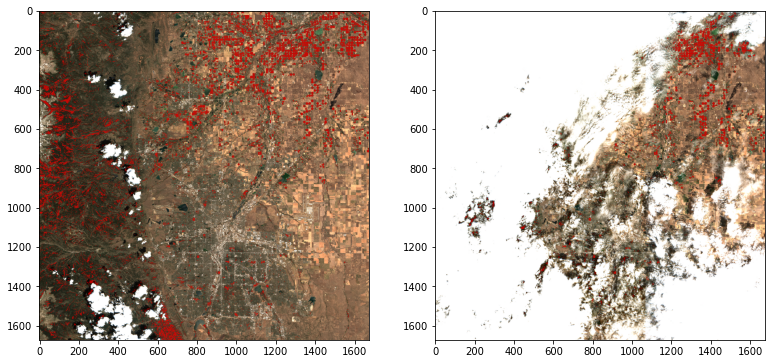

In [19]:
target_box = get_county_box(county_name='Broomfield', statefp=8, height=100, width=100, county_df=None)
print(target_box)
plt.figure(figsize=[13, 15])
plt.subplot(1, 2, 1)
image = get_NDVI_coverage(box=target_box, date=('2020-07-15', '2020-07-20'), resolution=60, config=config)
plt.imshow(image);
plt.subplot(1, 2, 2)
image = get_NDVI_coverage(box=target_box, date=('2020-07-20', '2020-07-25'), resolution=60, config=config)
plt.imshow(image);

### Measure changes in NDRE and NDVI for the region of the images not being covered by clouds

In [22]:
target_box = get_county_box(county_name='Broomfield', statefp=8, height=100, width=100, county_df=None)
image1 = get_NDRE(box=target_box, date=('2020-07-15', '2020-07-20'), resolution=60, config=config)
image2 = get_NDRE(box=target_box, date=('2020-07-20', '2020-07-25'), resolution=60, config=config)

pixel size = (1675, 1672)
pixel size = (1675, 1672)


In [4]:
np.mean(np.abs(image2[:, :, 0] - image1[:, :, 0]))

171.22877383417838

In [27]:
cond = (image1[:, :, 1] != 255) & (image2[:, :, 1] != 255)
np.nanmean(np.where(cond, image2[:, :, 0] > 120, np.nan))

In [29]:
np.nanmean(np.where(cond, image2[:, :, 0] > 120, np.nan))

0.08091460211678564

In [28]:
np.nanmean(np.where(cond, image1[:, :, 0] > 120, np.nan))

0.07794490737266635

### Multithreading to fasten the process

In [15]:
temp = {}
target_box = get_county_box(county_name='Broomfield', statefp=8, height=200, width=200, county_df=None)
timerange = []
for i in [2018]:
    i = str(i)
    for j in range(1, 13):
        j = str(j)
        if len(j) == 1:
            j = '0' + j
        timerange.append((i + '-' + j + '-01', i + '-' + j + '-28'))

In [17]:
%%time
request = {}
image = {}
lock = threading.Lock()
threads = [threading.Thread(target=get_NDRE_thread, args=((target_box), (elt), (200), (config))) for elt in timerange]

for t in threads:
    t.start()
for t in threads:
    t.join()

CPU times: user 923 ms, sys: 167 ms, total: 1.09 s
Wall time: 5.05 s


In [31]:
for i in range(len(timerange)-1):
    image1 = temp[timerange[i]]
    image2 = temp[timerange[i+1]]
    cond = (image1[:, :, 1] != 255) & (image2[:, :, 1] != 255)
    p1 = np.nanmean(np.where(cond, image1[:, :, 0] > 120, np.nan))*100
    p2 = np.nanmean(np.where(cond, image2[:, :, 0] > 120, np.nan))*100
    diff = (p2/p1-1)*100
    print(diff, p1, p2)

-40.50830453684093 1.655043908198657 0.9846136816471109
-54.29779239079381 0.43202811733956725 0.19744638711667395
721.2121212121211 0.20507442686941071 1.6840960509578877
156.56635695465263 1.223736171238212 3.13969531328223
47.44071868797661 3.243474003588049 4.782201381347908
8.413704907550489 4.758523987859641 5.158892154153154
-28.188145487202508 3.307515798697489 2.3751884333484328
-42.569740277586924 5.9161735844516095 3.3976738551793546
-38.6212507074137 3.9437562772012056 2.4206282780939627
-54.31125928170935 2.257874675809023 1.0315945063743301
0.8488964346349714 0.3674521033357664 0.37057139113997495


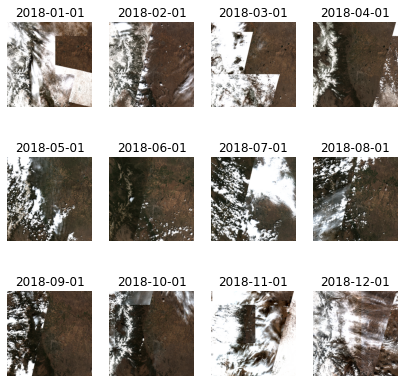

In [64]:
temp.sort(key=lambda x: x[0][0])
fig = plt.figure(figsize=[7, 7])
for i, elt in enumerate(temp):
    # print(elt[0])
    ax = fig.add_subplot(3, 4, i+1)
    temp.sort(key=lambda x: x[0][0])
    # plt.subplot(5, 5, i+1)
    ax.imshow(elt[1])
    ax.axis('off')
    ax.set_title(elt[0][0])

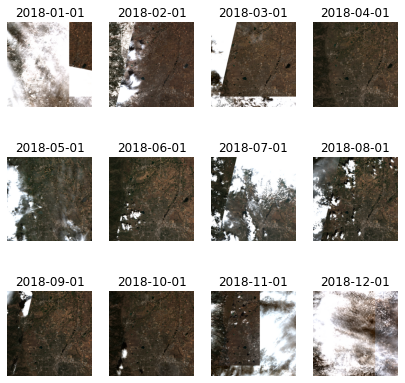

In [55]:
temp.sort(key=lambda x: x[0][0])
fig = plt.figure(figsize=[7, 7])
for i, elt in enumerate(temp):
    # print(elt[0])
    ax = fig.add_subplot(3, 4, i+1)
    temp.sort(key=lambda x: x[0][0])
    # plt.subplot(5, 5, i+1)
    ax.imshow(elt[1])
    ax.axis('off')
    ax.set_title(elt[0][0])

In [16]:
def get_NDRE_thread(box, date, resolution, config=None):
    time.sleep(0.1)
    bbox = BBox(box, crs=CRS.WGS84)
    size = bbox_to_dimensions(bbox, resolution=resolution)
    
    evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B05", "B08", "CLM"]
            }],
            output: {
                bands: 3,
            }
        };
    }

    function evaluatePixel(sample) {
        return [(sample.B08-sample.B05)/(sample.B08+sample.B05), sample.CLM];
    }
    """

    if not config:
        CLIENT_ID = '38f3a25e-448b-4fb7-8d86-12dae7ab0136'
        CLIENT_SECRET = '0Gf?B{PBWqV,wUhhb)AGjG6-72_;}l/6f5HE,9:4'
        config = SHConfig()
        config.sh_client_id = CLIENT_ID
        config.sh_client_secret = CLIENT_SECRET
        
    request[date] = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=date,
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=bbox,
        size=size,
        config=config
    )
    image[date] = request[date].get_data()[0]
    lock.acquire()
    temp[date] = image[date]
    lock.release()